In [4]:
from keras import preprocessing
import tensorflow as tf
import numpy as np
import pandas as pd
import xml.etree.ElementTree as xml
import keras
from keras.layers import Flatten, Dense, Dropout

In [5]:
#Importing data don't work correctly, we need to parse xml files to get info about photos

batch_size = 32

dataset = preprocessing.image_dataset_from_directory(
    r"..\data",
    validation_split=0.2,
    subset="training",
    seed=1337
)

Found 853 files belonging to 2 classes.
Using 683 files for training.


In [6]:
print(dataset)

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>


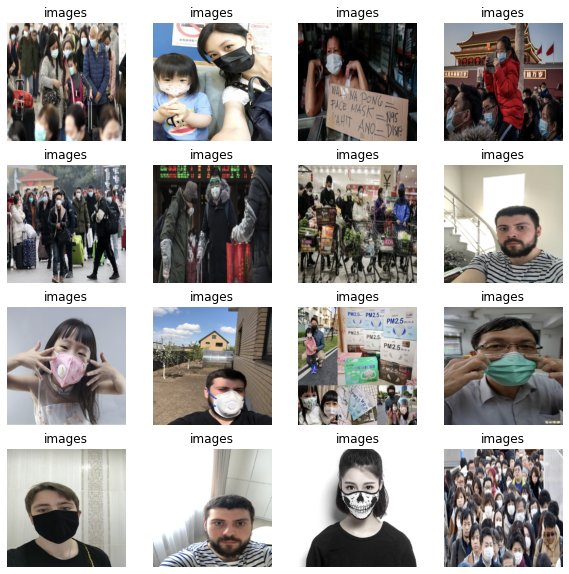

In [7]:
import matplotlib.pyplot as plt
 
class_names = dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [29]:
def parseXML(file_name):
    # Parse XML with ElementTree
    tree = xml.ElementTree(file=file_name)
    print(tree.getroot())
    root = tree.getroot()

    # get the information via the children!
    users = list(root)

In [30]:
parseXML(r"..\data\annotations\maksssksksss0.xml")

<Element 'annotation' at 0x000001586EAFB3B8>
[<Element 'folder' at 0x000001586EB15728>, <Element 'filename' at 0x000001586EB156D8>, <Element 'size' at 0x000001586EB15688>, <Element 'segmented' at 0x000001586EB154F8>, <Element 'object' at 0x000001586EB154A8>, <Element 'object' at 0x000001586EB15818>, <Element 'object' at 0x000001586EB15B88>]


In [7]:
input_shape = keras.Input
resnet_model = keras.applications.ResNet50(include_top=False, weights = None)

In [38]:
def make_model():
    """
    Creates a model
    As decribed in https://github.com/makatx/YOLO_ResNet,
    but it uses a lot of parameters, especially with extra dense layer
    it has enourmous amount of parameters.
    """
    model = keras.Sequential()
    model.add(keras.Input(shape=(243,243,3)))
    model.add(keras.applications.ResNet50(include_top=False, weights = None))
    model.add(Flatten(name="flatten_to_YOLO"))
    #model.add(Dense(4096, name='yolo_dense'))
    #model.add(Dropout(0.5, name='yolo_droupout'))

    # output tensor :
    # SS: Grid cells: 19*19
    # B: Bounding box per grid cell: 1
    # C: classes: 3
    # Coords: x, y, w, h per box: 4
    # tensor length: SS * (C +B(5) ) : 361*(3+5) => 2888
    model.add(Dense(19*19*(3+5), activation='linear', name='yolo_out'))
    return model

In [39]:
model = make_model()
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
flatten_to_YOLO (Flatten)    (None, 131072)            0         
_________________________________________________________________
yolo_out (Dense)             (None, 2888)              378538824 
Total params: 402,126,536
Trainable params: 402,073,416
Non-trainable params: 53,120
_________________________________________________________________


In [90]:
def make_model_v2(classes_num, anchor_num):
    """
    Make a better model, which outputted encoded 4d matrix of shape: (None,19,19,(C+4B)+1))
    I set anchor_num to one but we maybe have to change it to bigger number.
    """
    shape = (243,243,3)
    model = keras.Sequential()
    model.add(keras.Input(shape=shape))
    model.add(keras.applications.ResNet50(include_top=False, weights = None, input_shape=shape))
    model.add(keras.layers.Conv2D(filters=2048,kernel_size=3))
    model.add(keras.layers.MaxPooling2D())
    model.add(keras.layers.Conv2D(filters=(classes_num+1+4*anchor_num)*19*19,kernel_size=3))
    model.add(keras.layers.Reshape((19,19,8)))
    return model

In [89]:
model_v2 = make_model_v2(3,1)
model_v2.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 6, 6, 2048)        37750784  
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 2048)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 1, 1, 2888)        53234504  
_________________________________________________________________
reshape_1 (Reshape)          (None, 19, 19, 8)         0         
Total params: 114,573,000
Trainable params: 114,519,880
Non-trainable params: 53,120
_________________________________________________________________
